# Parsing of Anchore results

In [1]:
# Read distributions

In [2]:
with open('../train3.csv', 'r') as f:
    lines = f.readlines()
distros = { l.split(',')[0]: (l.split(',')[1], l.split(',')[3]) for l in lines[1:]}

In [3]:
distros
# image: (distro, n_packages)

{'gkiar/onevoxel:v0.3.0rc2': ('alpine:3.7.1', '71'),
 'bids/rshrf:1.0.1': ('alpine:3.8.4', '35'),
 'gkiar/mask2boundary:v0.1.0': ('alpine:3.9.0', '61'),
 'bids/broccoli:v1.0.0': ('centos:6', '253'),
 'mcin/docker-fsl:latest': ('centos:7', '145'),
 'bids/nipypelines:0.3.0': ('debian:8', '157'),
 'bids/baracus': ('ubuntu:14.04', '218'),
 'bids/rs_signal_extract:0.1': ('ubuntu:16.04', '241'),
 'bids/antscorticalthickness:v2.2.0-1': ('ubuntu:17.04', '291'),
 'bids/afni_proc': ('ubuntu:17.10', '277'),
 'mcin/ica-aroma:latest': ('centos:7', '159'),
 'bids/magetbrain': ('ubuntu:18.04', '167'),
 'mcin/qeeg:latest': ('centos:7', '171'),
 'bt5e/ants:latest': ('centos:7', '188'),
 'bigdatalabteam/hcp-prefreesurfer:exec-centos7-fslbuild-centos5-latest': ('centos:7',
  '240'),
 'bigdatalabteam/hcp-prefreesurfer:exec-centos7.freesurferbuild-centos4-latest': ('centos:7',
  '254'),
 'bids/brainiak-srm': ('ubuntu:16.04', '258'),
 'gkiar/dwipreproc_fsl-5.0.11_minified': ('ubuntu:16.04', '269'),
 'bids/m

In [4]:
len(distros)

38

In [5]:
import os.path as op
data_dir = '../Data/Anchore-New-Results'

# Find vulnerability file by image 
for d in distros:
    
    prefix, image = d.split('/')
    if prefix.upper() != 'BIDS' and prefix != 'poldracklab':
        prefix = 'Boutiques'
    else:
        prefix = 'BIDS'
    if ':' in image:
        image_name, version = image.split(':')
    else:
        image_name = image
        version = 'latest'
        
    # Handle hcp-prefreesurfer manually
    if image_name == 'hcp-prefreesurfer':
        if version == 'exec-centos7-fslbuild-centos5-latest':
            image_name = 'hcp-prefreesurfer1'
        if version == 'exec-centos7.freesurferbuild-centos4-latest':
            image_name = 'hcp-prefreesurfer2'
    
    file_name = op.join(data_dir, prefix, image_name) + '.csv'
    if not op.isfile(file_name):
        print(f'File not found: {file_name}')
    distros[d] = (file_name, distros[d][0], distros[d][1])

In [6]:
distros['bids/baracus']

('../Data/Anchore-New-Results/BIDS/baracus.csv', 'ubuntu:14.04', '218')

In [7]:
# List unique critical CVEs
import shlex
file_names = [distros[d][0] for d in distros]
critical = []
for file_name in file_names:
    with open(file_name, 'r') as f:
        lines = f.readlines()
    lines = [ shlex.split(line) for line in lines ][1:]
    critical += [(l[0], l[4]) for l in lines if l[2] == 'Critical']
critical = set(critical)
print(critical)
print(len(critical))

{('RHSA-2016:0370', 'https://access.redhat.com/errata/RHSA-2016:0370'), ('RHSA-2016:0176', 'https://access.redhat.com/errata/RHSA-2016:0176'), ('CVE-2017-5754', 'http://people.ubuntu.com/~ubuntu-security/cve/CVE-2017-5754'), ('RHSA-2017:1100', 'https://access.redhat.com/errata/RHSA-2017:1100'), ('RHSA-2015:1981', 'https://access.redhat.com/errata/RHSA-2015:1981')}
5


In [8]:
    # Get total vulnerabilities after minification
    with open('../Results_after_minification.csv', 'r') as f:
        lines = f.readlines()

    minifications = [ line.split(',') for line in lines[1:]]
    def get_after_minification(packages, vulnerabilities):
        for l in minifications:
            # TODO: check discrepancy in the number of vulnerabilities in Results_after_update2.csv
            if int(l[0]) == packages:# and int(l[1]) ==  vulnerabilities:
                return int(l[2].strip())

In [9]:
    # Get total vulnerabilities after update
    with open('../Results_after_update2.csv', 'r') as f:
        lines = f.readlines()

    updates = [ line.split(',') for line in lines[1:]]
    def get_after_updates(packages, vulnerabilities):
        for l in updates:
            # TODO: check discrepancy in the number of vulnerabilities in Results_after_update2.csv
            if int(l[0]) == packages:# and int(l[1]) ==  vulnerabilities:
                return int(l[2].strip())

In [10]:
    # Get total vulnerabilities after update AND minification
    with open('../Results_after_updateANDminification.csv', 'r') as f:
        lines = f.readlines()

    boths = [ line.split(',') for line in lines[1:]]
    def get_after_both(packages, vulnerabilities):
        for l in boths:
            if int(l[0]) == packages:# and int(l[1]) ==  vulnerabilities:
                return int(l[1].strip())

In [11]:
import pandas as pd
import shlex

df = pd.DataFrame(columns=['Abbrv', 'Image', 'Distribution', 'Version', 'Color',
                         'Negligible', 'Low', 'Medium', 'High', 'Critical',
                          'Total', 'Total_after_update', 'Total_after_minification', 'Total_after_both'])

distro_colors = {
    'ubuntu': 'xkcd:orangered',
    'debian': 'xkcd:teal', #'xkcd:crimson',
    'centos': 'xkcd:blue',
    'alpine': 'xkcd:lightblue'
}


for i, d in enumerate(distros):
    filename = distros[d][0]
    with open(filename, 'r') as f:
        lines = f.readlines()
    lines = [ shlex.split(line) for line in lines ][1:]
    
    def get_unique_vul(status, lines):
    #     negligible = sum([1 for x in lines if x[2] == 'Negligible'])
        cves = [x[0] for x in lines if x[2] == status]
        return len(set(cves))
    
    negligible = get_unique_vul('Negligible', lines)
    low = get_unique_vul('Low', lines)
    medium = get_unique_vul('Medium', lines)
    high = get_unique_vul('High', lines)
    critical = get_unique_vul('Critical', lines)
    total = negligible + low + medium + high + critical
    
    # Total number of packages
    packages = int(distros[d][2])
    
    # Set abbreviations to be used in figures
    abbrv = d.split('/')[1]
    if ':' in abbrv:
        abbrv = abbrv.split(':')[0]
    collisions = ['ndmg', 'hcp-prefreesurfer', 'fmriprep']
    if abbrv in collisions:
        abbrv += str(i % 2)

    ascii = 65 + i
    if ascii > 90:
        ascii += 6
    abbrv = chr(ascii) + " "
    
    # Get vulnerabilities after update
    after_update = get_after_updates(packages, total)
    after_minification = get_after_minification(packages, total)
    both = get_after_both(packages, total)

    if d == 'bids/afni_proc': # npackage-based calculations doesn't work here
        after_update = None
        after_minification = None
        both = None
        
    
    df = df.append({
        'Image': d,
        'Abbrv': abbrv,
        'Distribution': distros[d][1].split(':')[0],
        'Version': distros[d][1].split(':')[1],
        'Color': distro_colors[distros[d][1].split(':')[0]],
        'Packages': packages,
        'Negligible': negligible,
        'Low': low,
        'Medium': medium,
        'High': high,
        'Critical': critical,
        'Total': total,
        'Total_after_update': after_update,
        'Total_after_minification': after_minification,
        'Total_after_both': both
    }, ignore_index=True)

In [12]:
df = df.sort_values('Total', ascending=False)
df

,Abbrv,Image,Distribution,Version,Color,Negligible,Low,Medium,High,Critical,Total,Total_after_update,Total_after_minification,Total_after_both,Packages
36,k,bids/hyperalignment,ubuntu,16.04,xkcd:orangered,100,594,971,50,1,1716,440,None,None,815.0
37,l,bids/niak,ubuntu,16.04,xkcd:orangered,106,557,783,35,1,1482,None,None,None,889.0
33,h,bids/fibredensityandcrosssection,ubuntu,14.04,xkcd:orangered,79,427,545,34,1,1086,340,None,None,566.0
31,f,bids/ndmg:v0.1.0,ubuntu,14.04,xkcd:orangered,79,387,448,20,0,934,333,930,0,537.0
32,g,bids/ndmg,ubuntu,14.04,xkcd:orangered,79,387,448,20,0,934,333,None,None,538.0
35,j,bids/oppni:v0.7.0-1,ubuntu,14.04,xkcd:orangered,76,371,438,27,1,913,344,None,None,762.0
16,Q,bids/brainiak-srm,ubuntu,16.04,xkcd:orangered,54,365,431,46,1,897,279,None,None,258.0
30,e,bids/tracula:v6.0.0-4,ubuntu,14.04,xkcd:orangered,76,360,415,22,1,874,329,None,None,530.0
7,H,bids/rs_signal_extract:0.1,ubuntu,16.04,xkcd:orangered,61,378,383,44,1,867,277,None,None,241.0
29,d,bids/example,ubuntu,14.04,xkcd:orangered,76,358,385,19,0,838,181,523,76,528.0


In [13]:
len(df)

38

In [14]:
df['Total'].mean()

465.86842105263156

In [15]:
df['Total'].median()

372.0

# Figures

## Vulnerabilities overview

In [16]:
def vul_plot(ax):
    from numpy import zeros
    ax.invert_yaxis()

    statuses = [ 'Negligible', 'Low', 'Medium', 'High', 'Critical']
    critical_color = 'red'

    height=0.9
    cumulatives = zeros(len(df))
    for i, status in enumerate(statuses):
        values = df[status].to_numpy()
        alpha = (i+1)/(len(statuses))
        color = df['Color']
        if status == 'Critical':
            color = critical_color
        ax.barh(df['Abbrv'], values, height=height, label=status, left=cumulatives,
            color=color, alpha=alpha)
        if status == 'Critical': # add text label
            for i, value in enumerate(values):
                if value != 0:
                    pos_x = cumulatives[i] + value + 10
                    pos_y = i + height/4
                    ax.text(pos_x, pos_y, f'({value})', color=color, fontsize=label_size)
#         for i, value in enumerate(values):
#             # Value labels
#             pos_x = cumulatives[i] + value/2 - 20
#             pos_y = i + height/4
#             if alpha <= 0.5:
#                 color = 'black'
#             else:
#                 color = 'white'
#             if value >= 50:
#                 ax.text(pos_x, pos_y, value, color=color, fontsize=label_size)

        cumulatives = cumulatives + values

    
    import matplotlib.patches as mpatches


    color_labels = {distro_colors[d]: d for d in set(df['Distribution'])}
    patches = [ mpatches.Patch(color=x, label=color_labels[x].title()) for x in color_labels]
    legend1 = ax.legend(handles=patches, bbox_to_anchor=(1, 1), ncol=1, loc='lower left',
                        fontsize=label_size, title='OS distribution')

    patches = []
    for i in range(len(statuses)):
        alpha = (i+1)/len(statuses)
        color = (0, 0, 0, alpha)
        if i == 4:
            color = critical_color
        label = statuses[i]
        if label == 'Critical':
            label += ' (n)'
        patches += [ mpatches.Patch(color=color, label=label)]

    # Add the second legend (this removes the first one)
    ax.legend(handles=patches, bbox_to_anchor=(0.15, 1), ncol=5, loc='lower left',
             fontsize=label_size, title='Severity')
    ax.legend_.set_frame_on(False)

    ax.tick_params(axis="x")
    ax.set_xlabel('Number of vulnerabilities')
    ax.set_ylabel('Container image')

    # Add the first legend back
    legend1.set_frame_on(False)
    ax.add_artist(legend1)

    ax.set_frame_on(False)
    ax.set_axis_on()
    ax.set_axisbelow(True)

    ax.xaxis.grid()
    ax.xaxis.set_ticks([0, 500, 1000, 1500])
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylim(len(df)-height/2, -height/2)
    ax.set_xlim(0, 1750)


#     import matplotlib.lines as mlines
#     l = mlines.Line2D([0,1715], [37.5, 37.5], color='black', linewidth=3, alpha=1)
#    ax.add_line(l)

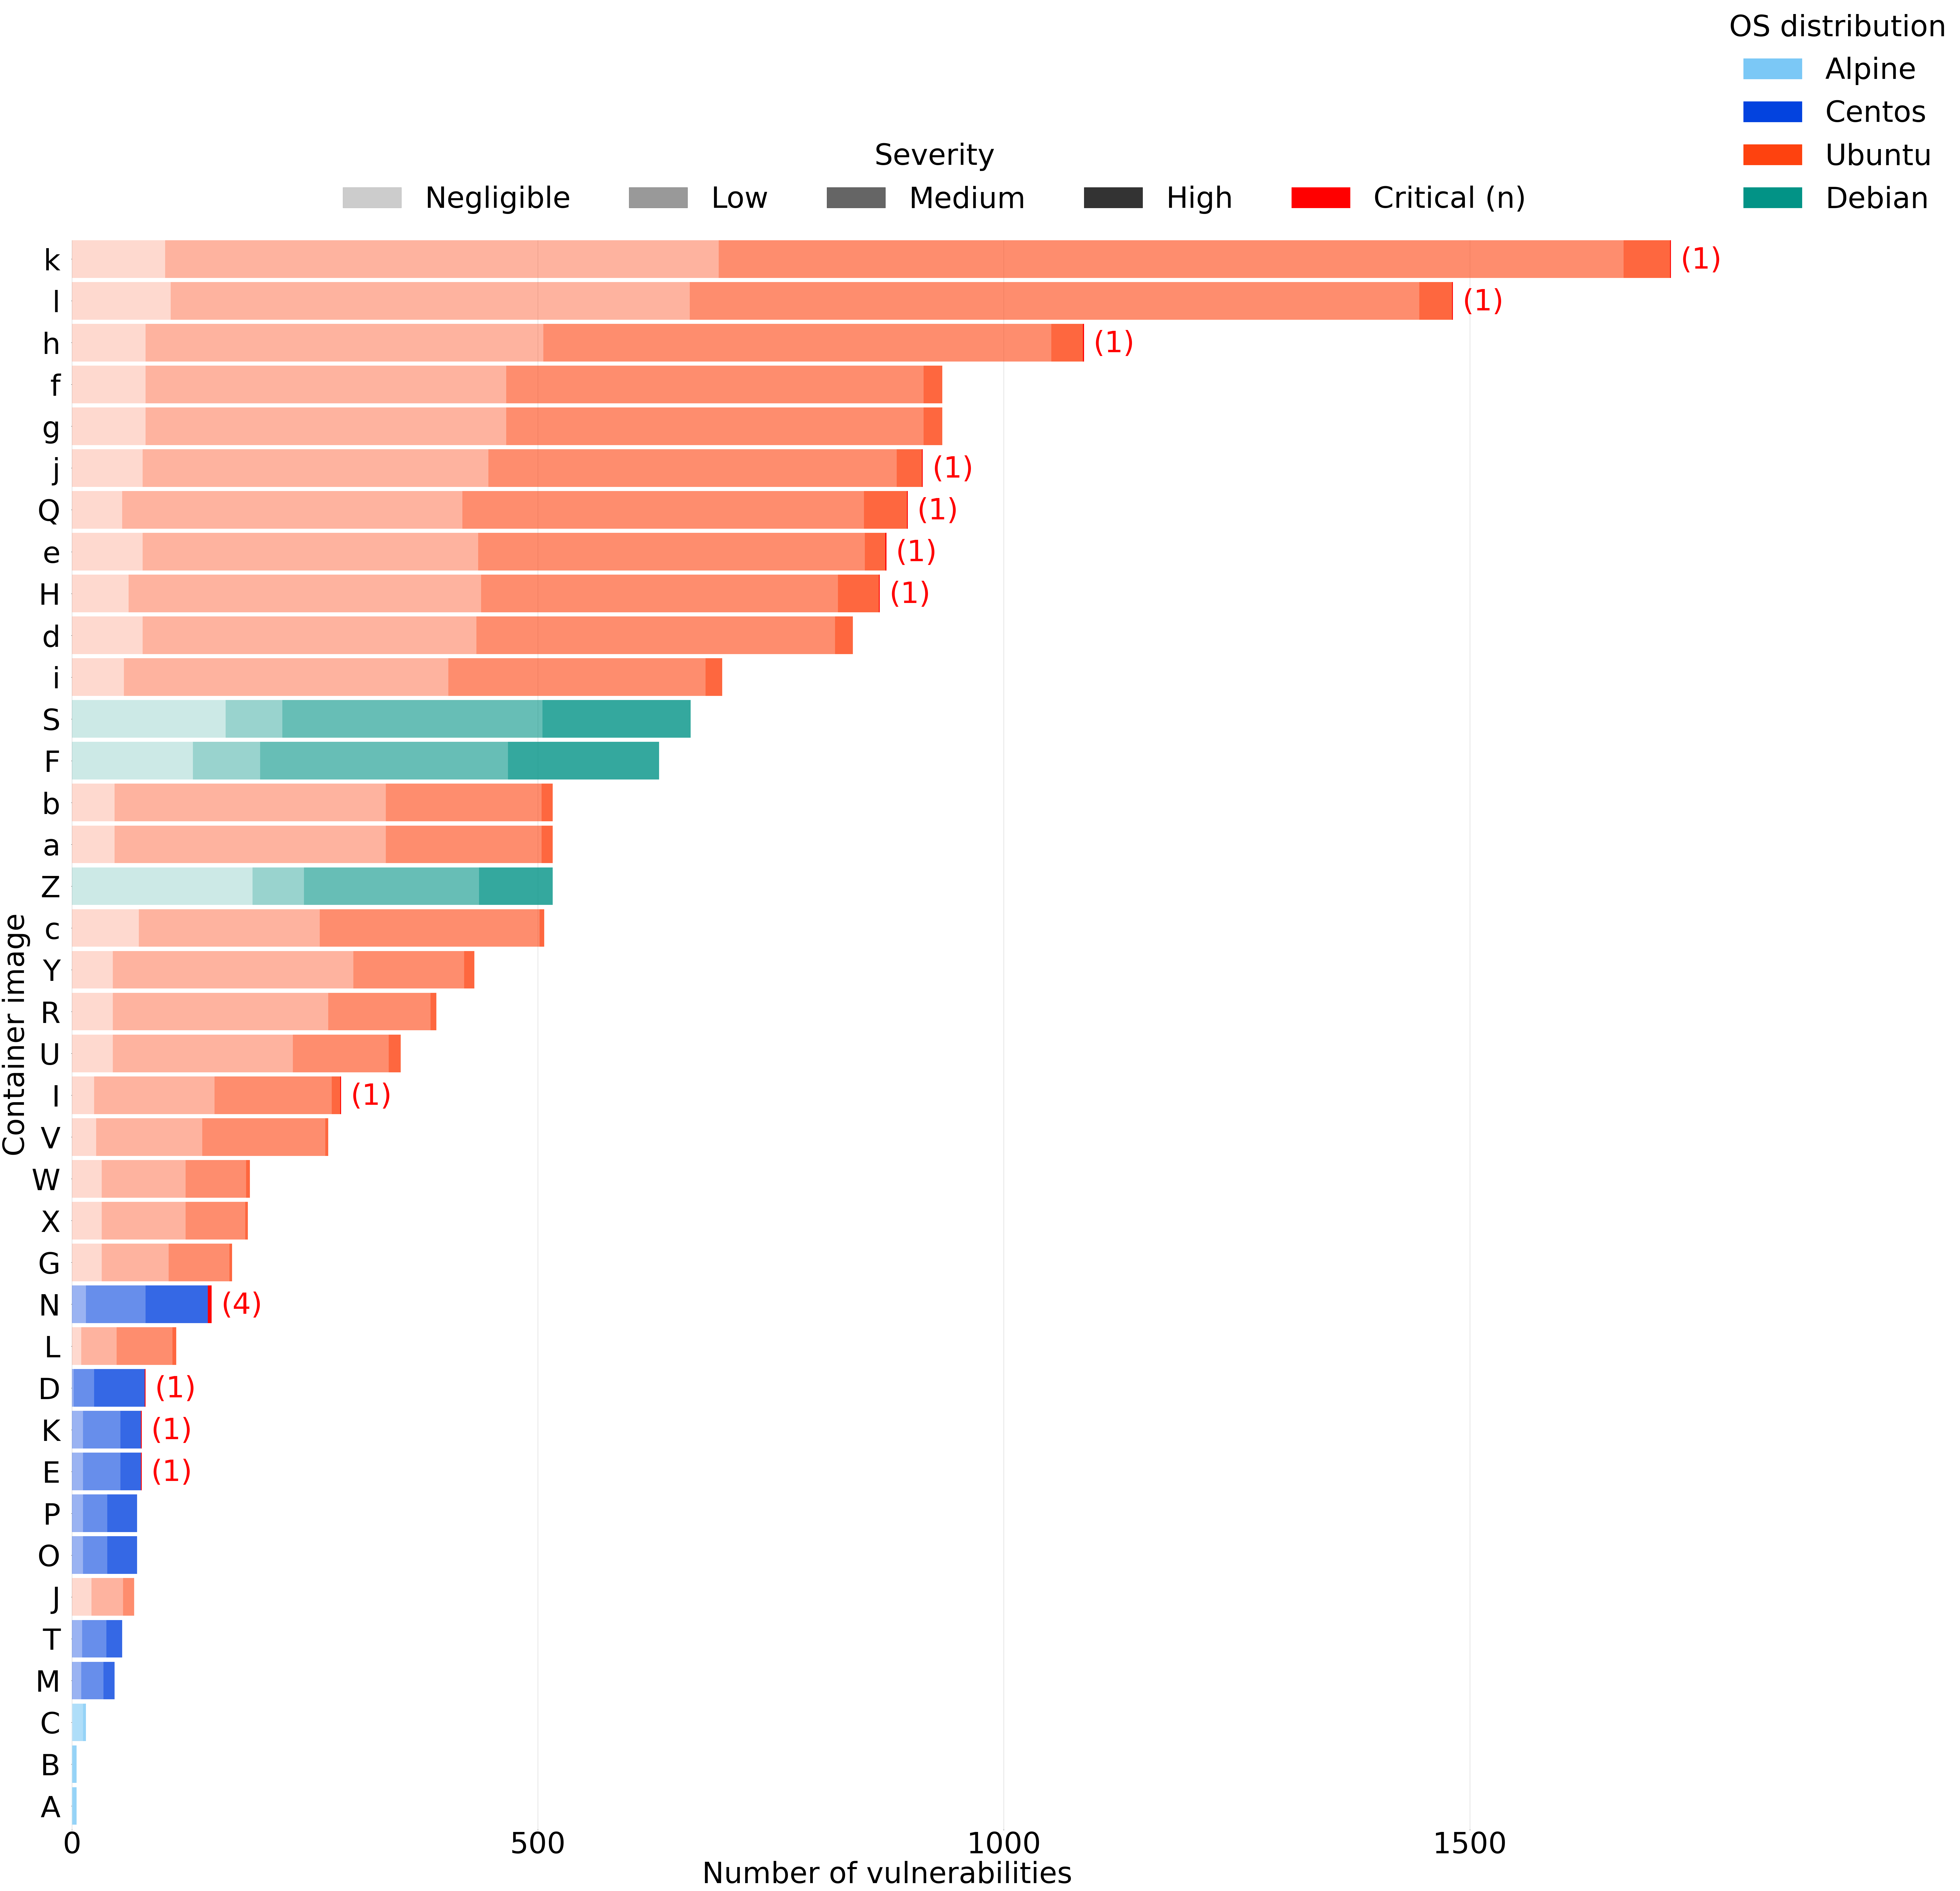

In [17]:
import matplotlib
from matplotlib import pyplot as plt

# Define font size
label_size = 100
font = {'size': label_size}
matplotlib.rc('font', **font)

# Increaes figure size
fig, ax = plt.subplots(figsize=(100, 100))
vul_plot(ax)


plt.savefig('../Figures/by_status.pdf', bbox_inches="tight")
plt.show()

## Vulnerabilities by number of packages, before and after update

In [18]:
def update_plot(ax, ay):    
    import scipy.stats
    import numpy as np

    size = 10000
    packages = df['Packages'].to_numpy()
    total = df['Total'].to_numpy().astype(np.float)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(packages, total)
    print(f'Before update: p={p_value}')
    ax.plot(packages, intercept + slope*packages, color='black', linewidth=3)
    ax.scatter(df['Packages'],df['Total'], s=size, color=df['Color'], alpha=0.75, marker='o')
    ax.text(700, 1200, f'y={round(slope,1)}x-{abs(round(intercept,1))}\nr={round(r_value,2)}')

    df1 = df[df.Total_after_update >= 0 ] # filters None
    packages = df1['Packages'].to_numpy()
    total = df1['Total_after_update'].to_numpy().astype(np.float)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(packages, total)
    print(f'After update: p={p_value}')
    ay.plot(packages, intercept + slope*packages, color='black', linewidth=3)
    ay.scatter(df['Packages'],df['Total_after_update'], s=size, color=df['Color'], alpha=0.75, marker='o')
    ay.text(700, 500, f'y={round(slope,1)}x-{abs(round(intercept,1))}\nr={round(r_value,2)}')

    ymin = -50
    ymax = 1750
    xmin = 0
    xmax = 900
    for a in [ax, ay]:
        a.set_ylim(ymin, ymax)
        a.set_xlim(xmin, xmax)
        a.set_xlabel('Number of packages')

    ax.set_title('Before update')
    ax.set_ylabel('Number of vulnerabilities')
    ay.set_title('After update')


In [19]:
# Increaes figure size
fig, (ax, ay) = plt.subplots(1, 2, figsize=(200, 100))
update_plot(ax, ay)
plt.savefig('../Figures/update.pdf', bbox_inches="tight")
plt.show()

Before update: p=9.03271246507385e-11
After update: p=2.0033332887070155e-08


## Vulnerabilities after minification

In [20]:
df1 = df[df.Total_after_both >= 0 ] # filters None
df1

,Abbrv,Image,Distribution,Version,Color,Negligible,Low,Medium,High,Critical,Total,Total_after_update,Total_after_minification,Total_after_both,Packages
31,f,bids/ndmg:v0.1.0,ubuntu,14.04,xkcd:orangered,79,387,448,20,0,934,333,930,0,537.0
29,d,bids/example,ubuntu,14.04,xkcd:orangered,76,358,385,19,0,838,181,523,76,528.0
18,S,bids/mindboggle:0.0.4-1,debian,8,xkcd:teal,165,61,279,159,0,664,201,187,44,277.0
26,a,poldracklab/fmriprep:1.2.3,ubuntu,16.04,xkcd:orangered,46,291,167,12,0,516,352,574,338,441.0
20,U,bids/freesurfer,ubuntu,14.04,xkcd:orangered,44,193,103,13,0,353,224,101,76,298.0


In [21]:
def minif_plot(ax):
    from numpy import arange
    width=0.3
    ax.invert_yaxis()
    ax.barh(arange(5), df1['Total'], width, color=df1['Color'], alpha=0.1)
    ax.barh(arange(5)+width, df1['Total'], width, color=df1['Color'], alpha=0.1)
    ax.barh(arange(5)+width*2, df1['Total'], width, color=df1['Color'], alpha=0.1)

    ax.barh(arange(5), df1['Total_after_update'], width, color=df1['Color'],  alpha=0.25)
    ax.barh(arange(5)+width, df1['Total_after_minification'], width, color=df1['Color'], alpha=0.5)
    ax.barh(arange(5)+2*width, df1['Total_after_both'], width, color=df1['Color'], alpha=0.75)

    operations = ['None', 'Update', 'Minification', 'Update & Minification']
    import matplotlib.patches as mpatches
    patches = []
    for i in range(4):
        if i == 0:
            alpha = 0.1
        else:
            alpha = i/4
        patches += [ mpatches.Patch(color=(0, 0, 0, alpha), label=operations[i])]

    # Add the second legend (this removes the first one)
    ax.legend(handles=patches, bbox_to_anchor=(0.15, 1), ncol=5, loc='lower left', fontsize=label_size,
              title='Operation applied')
    ax.legend_.set_frame_on(False)

#     secy = ax.secondary_yaxis('right')

#     secy.set_yticklabels(['update', 'minification', 'both'])
#     secy.set_yticks([0, width, 2*width])

    ax.set_yticklabels(df1['Abbrv'])
    ax.set_yticks(width+arange(5))

    ax.set_frame_on(False)
    
    ax.xaxis.grid()
    ax.xaxis.set_ticks([0, 500, 1000, 1500])
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlim(0, 1750)

    ax.set_ylabel('Container image')
    ax.set_xlabel('Number of vulnerabilities')

<ipython-input-21-52d3fe780040>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df1['Abbrv'])


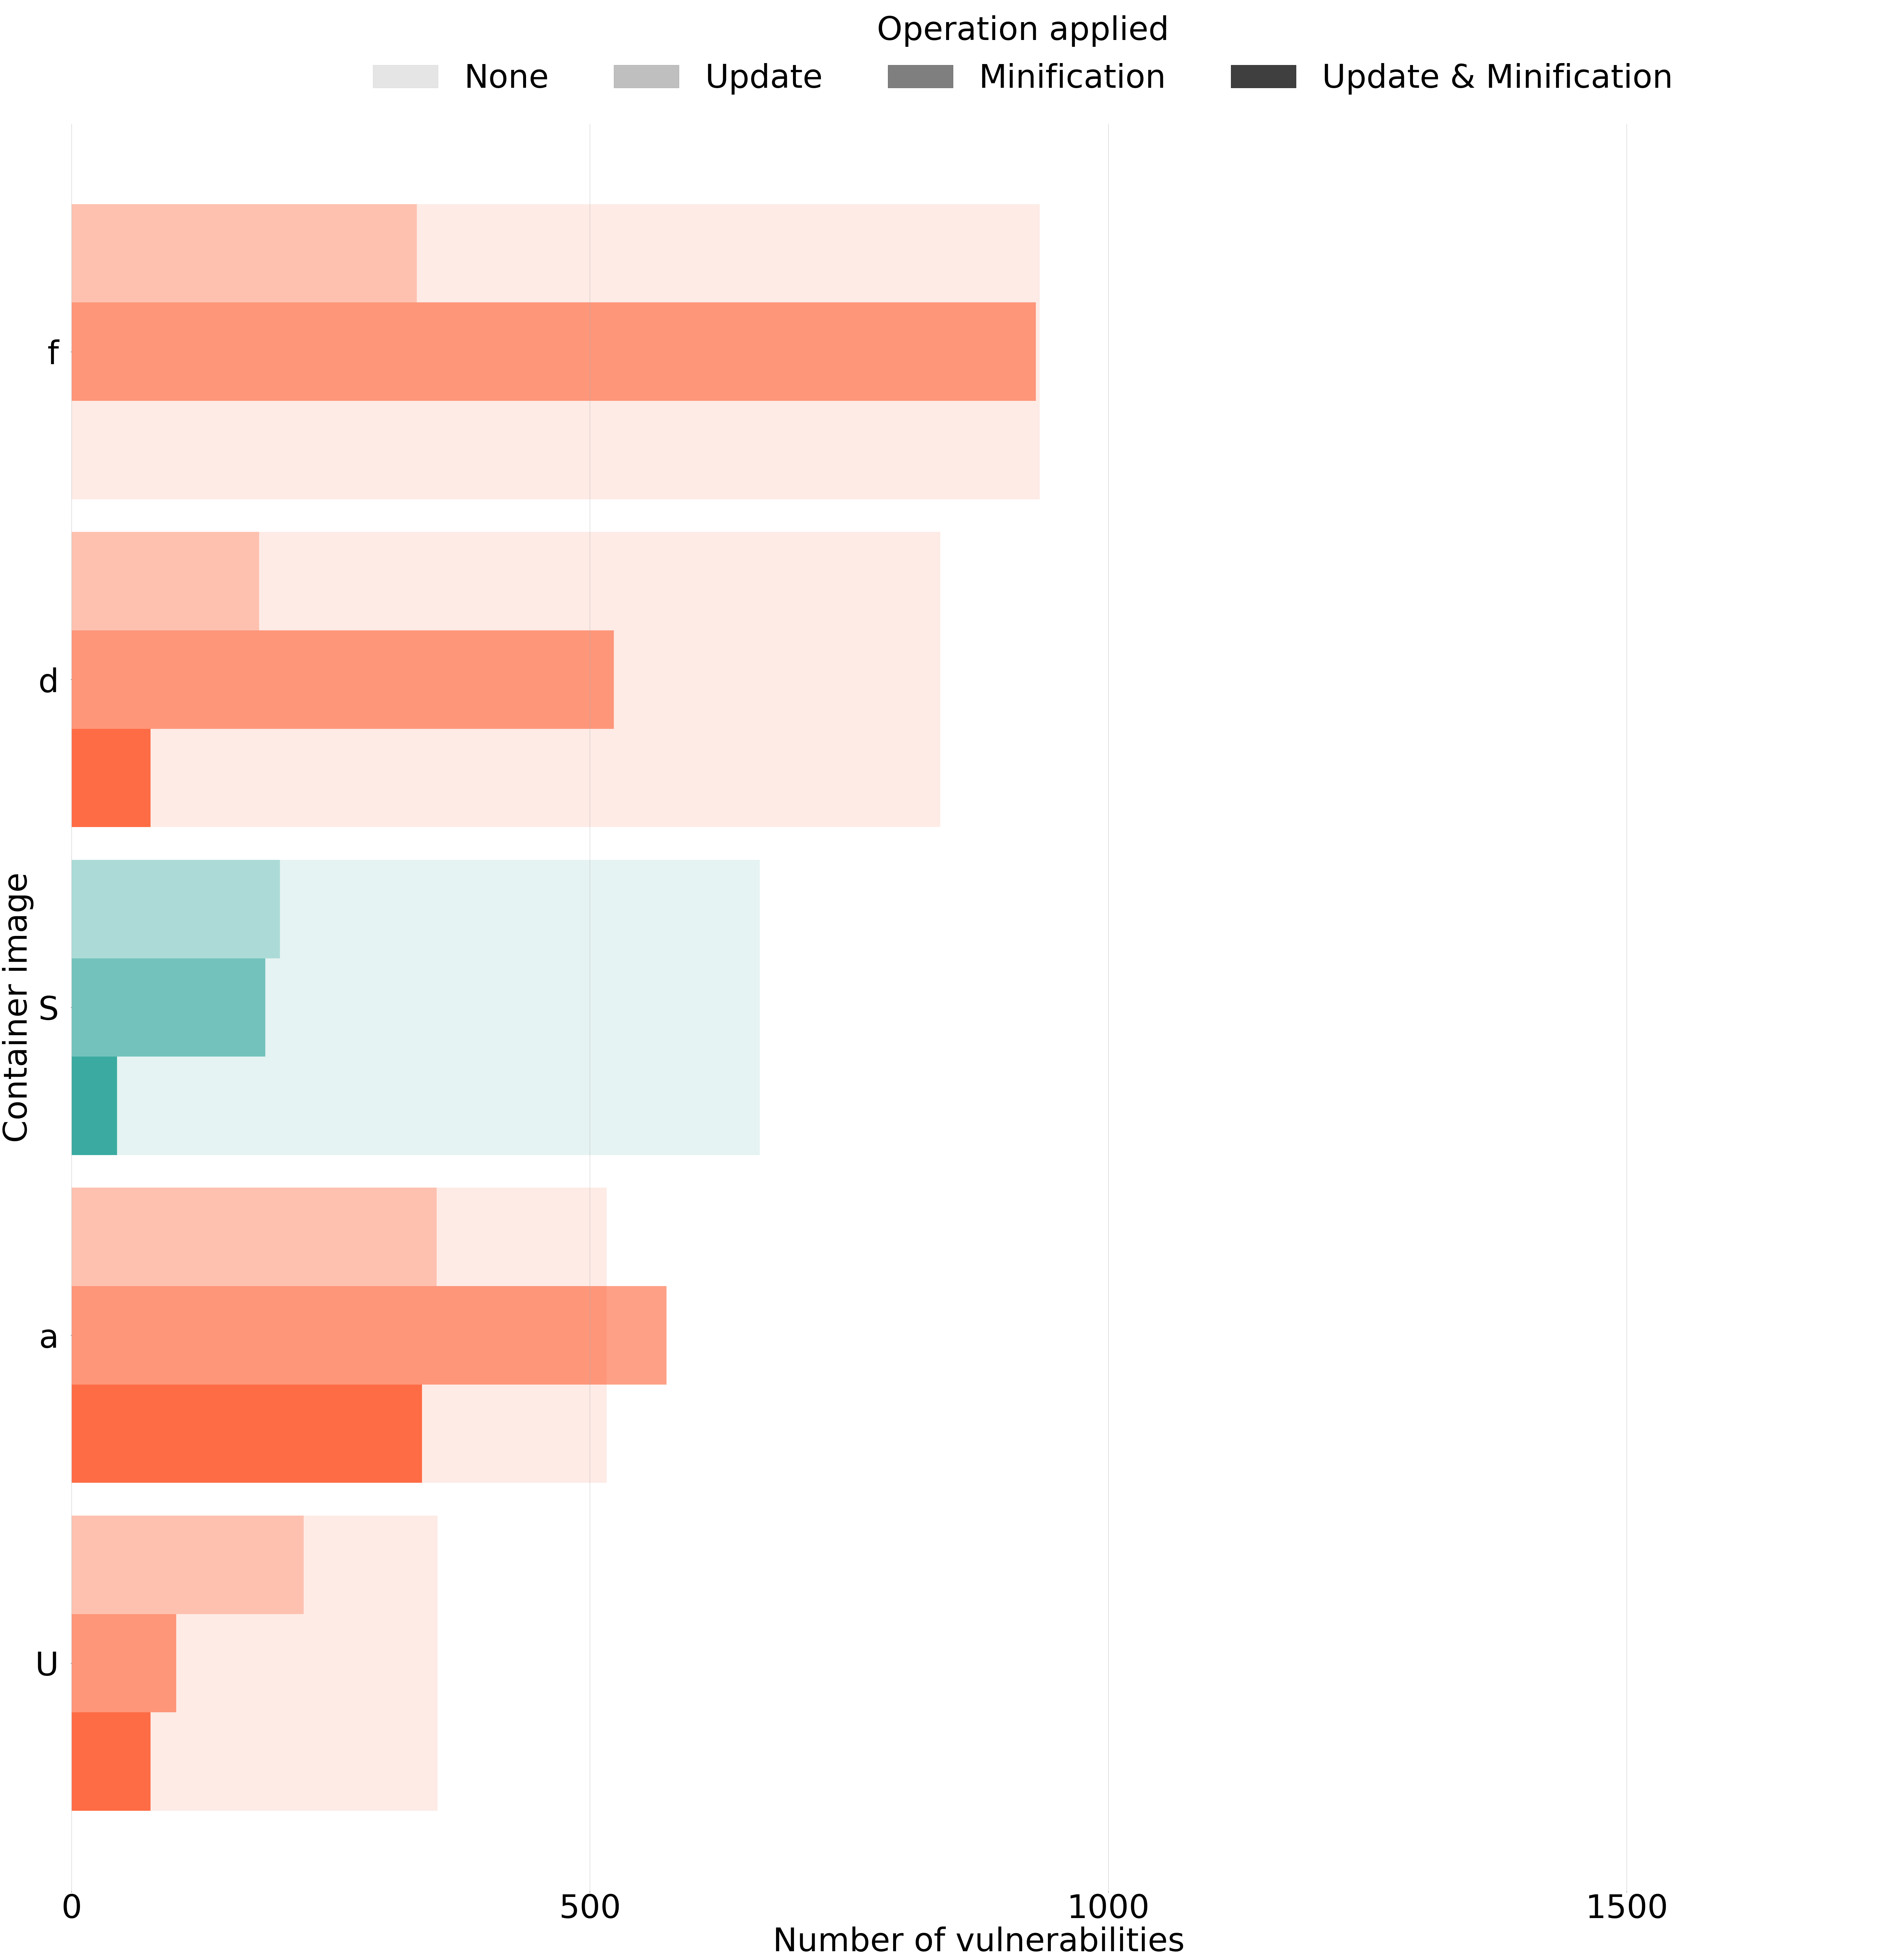

In [22]:
# Increaes figure size
fig, ax = plt.subplots(figsize=(100,100))

minif_plot(ax)
plt.savefig('../Figures/update_and_minif.pdf', bbox_inches="tight")
plt.show()

## Putting all the figures together

In [23]:
from matplotlib import pyplot as plt
from numpy import zeros

# Define font size
label_size = 100
font = {'size': label_size}
matplotlib.rc('font', **font)

# Increaes figure size
fig, axs = plt.subplots(2, 2, figsize=(200,200))

label = [ 'A', 'B', 'C', 'D']
for i, ax in enumerate((axs[0,0], axs[0,1], axs[1,0], axs[1,1])):
    offset = 1.1
    ax.text(0, offset, label[i], transform=ax.transAxes,
          fontsize=200, fontweight='bold', va='top', ha='right')


vul_plot(axs[0,0])
minif_plot(axs[0, 1])
update_plot(axs[1,0], axs[1,1])
plt.savefig('../Figures/figure.pdf', bbox_inches="tight")
plt.show()

<ipython-input-21-52d3fe780040>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df1['Abbrv'])


Before update: p=9.03271246507385e-11
After update: p=2.0033332887070155e-08


# Comparison between scanners

In [ ]:
# Clair

